<a href="https://colab.research.google.com/github/Lucs1590/study_segmentation/blob/main/medical_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation on Medical Area

# Libraries Import

In [3]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
from glob import glob
from imageio import mimread
from google.colab.patches import cv2_imshow
tensorflow.__version__

'2.8.2'

In [4]:
seed = 27
np.random.seed = seed  
random.seed = seed
tensorflow.random.set_seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading Dataset

In [6]:
!cp /content/gdrive/MyDrive/image-segmentation-course/datasets/drive_dataset.zip /content/

In [7]:
!unzip drive_dataset.zip -d /content/

Archive:  drive_dataset.zip
 extracting: /content/drive_dataset/test.zip  
 extracting: /content/drive_dataset/training.zip  


In [8]:
!unzip drive_dataset/training.zip -d /content/drive_dataset/
!unzip drive_dataset/test.zip -d /content/drive_dataset/

Archive:  drive_dataset/training.zip
   creating: /content/drive_dataset/training/1st_manual/
 extracting: /content/drive_dataset/training/1st_manual/21_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/22_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/23_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/24_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/25_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/26_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/27_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/28_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/29_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/30_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/31_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/32_manual1.gif  
 extracting: /content/drive_da

In [9]:
def load_dataset(caminho):
  X_train = sorted(glob(os.path.join(caminho, "training", "images", "*.tif")))
  y_train = sorted(glob(os.path.join(caminho, "training", "1st_manual", "*.gif")))

  X_test = sorted(glob(os.path.join(caminho, "test", "images", "*.tif")))
  y_test = sorted(glob(os.path.join(caminho, "test", "1st_manual", "*.gif")))

  return (X_train, y_train), (X_test, y_test)

In [10]:
path_dataset = "drive_dataset"
(X_train, y_train), (X_test, y_test) = load_dataset(path_dataset)

In [11]:
len(X_train), len(y_train)

(20, 20)

In [12]:
len(X_test), len(y_test)

(20, 20)

In [13]:
img_heigth = 512
img_widht = 512

# Data augmentation

- Albumentation: https://github.com/albumentations-team/albumentations

The used transformations:

* [HorizontalFlip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.HorizontalFlip) - Mirror the image horizontally

* [VerticalFlip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.VerticalFlip) - Mirror the image vertically

* [OpticalDistortion](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.OpticalDistortion) -Optical distortions, which mimic distortions caused by lenses in photography e.g. barrel-type and pillow-type distortion

* [ElasticTransform](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.ElasticTransform) - Distortions in the image structure, for example that ripple effect on the image

* [GridDistortion](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GridDistortion) - Distortions in the grid of the image, causing the effect of variations in the distribution along the image (as if the image seen from above had some "mountains", where some regions are more "close" and others are further away)


In [14]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dj5ge3k3
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dj5ge3k3
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.1-py3-none-any.whl size=116845 sha256=57d42a5b472f0d04c8a37552bf33f2adb00a2e598c7fbd4272caea98bffdaef3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbye2pdg/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [15]:
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout

In [16]:
def create_dir(_path):
  if not os.path.exists(_path):
    os.makedirs(_path)

In [17]:
create_dir('final_dataset/train/images')
create_dir('final_dataset/train/mask')

create_dir('final_dataset/test/images')
create_dir('final_dataset/test/mask')

In [18]:
def apply_augs(img, mask, aug_filters):
  X_list = [img]
  Y_list = [mask]
  for aug_filter in aug_filters:
    augmentation = aug_filter(image=img, mask=mask)
    x_result = augmentation['image']
    y_result = augmentation['mask']
    X_list.append(x_result)
    Y_list.append(y_result)
  return X_list, Y_list


In [22]:
def new_images(images, masks, save_dir, img_heigth=512, img_widht=512, augmentation=True):
  for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total = len(images)):
    name = x.split('/')[-1].split('.')[0]

    x = cv2.imread(x)
    y = mimread(y)[0]

    if augmentation:
      transformations = [
        HorizontalFlip(p = 1.0),
        VerticalFlip(p = 1.0),
        OpticalDistortion(p = 1.0, distort_limit = 2, shift_limit=0.5),
        ElasticTransform(p = 1.0, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p = 1.0)
      ]
      X, y = apply_augs(x, y, transformations)

    else:
      X = [x]
      y = [y]

    idx = 0
    for img, mask in zip(X, y):
      img = cv2.resize(img, (img_widht, img_heigth))
      mask = cv2.resize(mask, (img_widht, img_heigth))

      if len(X) == 1:
        tmp_img_name = f"{name}.png"
        tmp_mask_name = f"{name}.png"
      else:
        tmp_img_name = f"{name}_{idx}.png"
        tmp_mask_name = f"{name}_{idx}.png"

      image_path = os.path.join(save_dir, "images", tmp_img_name)
      mask_path = os.path.join(save_dir, "mask", tmp_mask_name)

      cv2.imwrite(image_path, img)
      cv2.imwrite(mask_path, mask)

      idx += 1

In [20]:
new_images(X_train, y_train, 'final_dataset/train/', augmentation=True)

100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


In [21]:
new_images(X_test, y_test, 'final_dataset/test/', augmentation=False)

100%|██████████| 20/20 [00:01<00:00, 11.59it/s]


In [23]:
generated_train_dir = 'final_dataset/train/'
generated_imgs = [os.path.join(f'{generated_train_dir}images', f) for f in os.listdir(f'{generated_train_dir}images')]
generated_masks = [os.path.join(f'{generated_train_dir}mask', f) for f in os.listdir(f'{generated_train_dir}mask')]

In [25]:
len(generated_imgs), len(generated_masks)

(120, 120)

In [27]:
20 * 5 + 20
# total images * numb. transformations + raw images

120

24_training_2
26_training_3
39_training_3
21_training_0
28_training_2
22_training_2
28_training_4
28_training_5
34_training_5
27_training_4


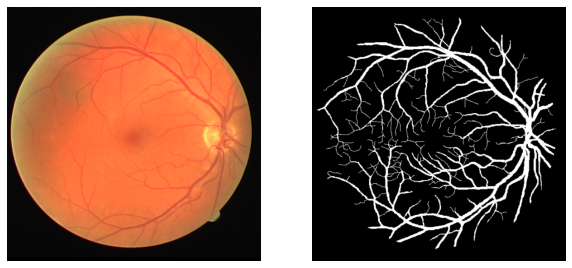

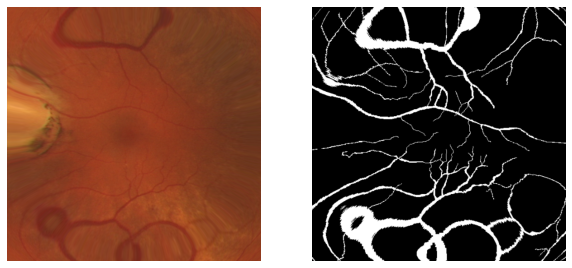

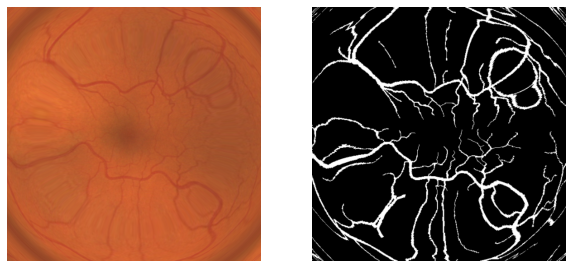

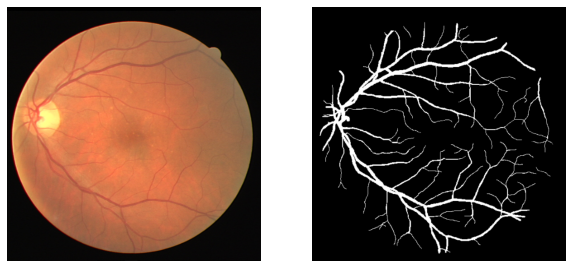

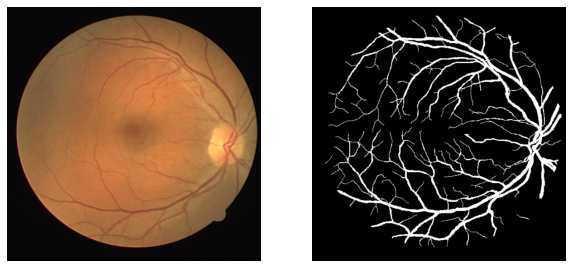

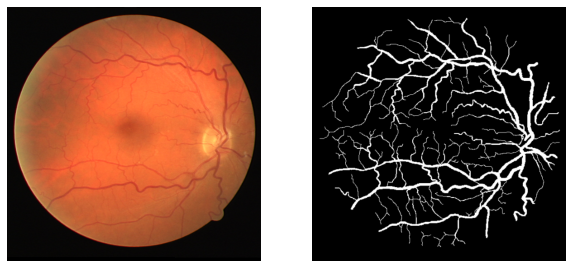

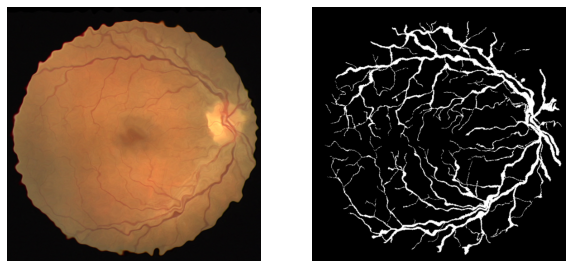

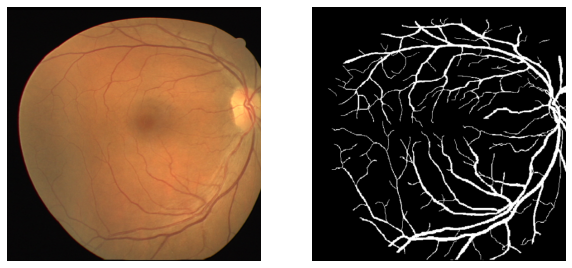

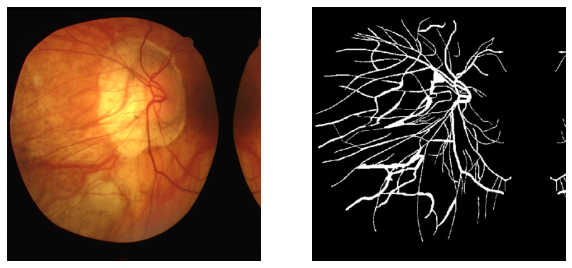

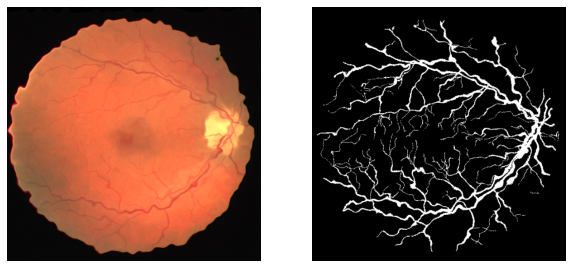

In [30]:
for i in range(10):
  fig = plt.figure(figsize=(10,7))

  print(generated_imgs[i].split('/')[-1].replace('.png',''))
  fig.add_subplot(1,2,1)
  img_teste = cv2.imread(generated_imgs[i])
  plt.imshow(cv2.cvtColor(img_teste, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  fig.add_subplot(1,2,2)
  mask_teste = cv2.imread(generated_masks[i])
  plt.imshow(cv2.cvtColor(mask_teste, cv2.COLOR_BGR2RGB))
  plt.axis('off')

# Neural Networking Building

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Recall, Precision

def convolution_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, num_filters):
  x = convolution_block(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = convolution_block(x, num_filters)
  return x


def unet_model(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = convolution_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name='UNet')
  return model

https://github.com/keras-team/keras/issues/3611)

* IoU e Dice Coefficient https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

* Dice Loss - https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

In [32]:
from keras import backend as K

""" IoU """
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

""" Dice Coefficient """
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

""" Dice Coefficient Loss """
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [33]:
epochs = 50
batch_size = 2
lr = 1e-4

In [34]:
model = unet_model((img_heigth, img_widht, 3))
model.compile(loss=dice_coef_loss, optimizer=Adam(lr), metrics = [dice_coef, iou, 'accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

# Loading Images

In [35]:
def load_images(path):
  x = sorted(glob(os.path.join(path, 'images', '*.png')))
  y = sorted(glob(os.path.join(path, 'mask', '*.png')))
  return x, y

In [36]:
def read_dataset_image(path):
  path = path.decode()
  img = cv2.imread(path)
  img = img / 255.0
  img = img.astype(np.float32)
  return img

In [37]:
def read_dataset_maks(path):
  path = path.decode()
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = img / 255.0
  img = img.astype(np.float32)
  img = np.expand_dims(img, axis = -1) # (512, 512) -> (512, 512, 1)
  return img

In [38]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_dataset_image(x)
    y = read_dataset_maks(y)
    return x, y

  x, y = tensorflow.numpy_function(_parse, [x, y], [tensorflow.float32, tensorflow.float32])
  x.set_shape([img_heigth, img_widht, 3])
  y.set_shape([img_heigth, img_widht, 1])
  return x, y

In [39]:
def tf_dataset(X, y, batch_size=2):
  dataset = tensorflow.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(4)
  return dataset

In [40]:
from sklearn.utils import shuffle
def shuffle_data(x, y, seed=42):
  x, y = shuffle(x, y, random_state=seed)
  return x, y

In [41]:
dataset_dir = 'final_dataset'
train_path = os.path.join(dataset_dir, 'train')
validation_path = os.path.join(dataset_dir, 'test')
print(train_path, validation_path)

final_dataset/train final_dataset/test


In [42]:
X_train, y_train = load_images(train_path)
X_train, y_train = shuffle_data(X_train, y_train)
X_val, y_val = load_images(validation_path)

In [43]:
len(X_train), len(y_train)

(120, 120)

In [44]:
len(X_val), len(y_val)

(20, 20)

In [46]:
train_dataset = tf_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = tf_dataset(X_val, y_val, batch_size=batch_size)

In [47]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

# Training

In [48]:
model_path = 'models'
create_dir(model_path)

In [50]:
callbacks = [ModelCheckpoint(model_path + '/drive_model_{epoch:02d}.h5', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=5)]

In [51]:
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6583 - dice_coef: 0.3417 - iou: 0.2103 - accuracy: 0.7057
Epoch 1: val_loss improved from inf to 0.86154, saving model to models/drive_model_01.h5
60/60 [==============================] - 33s 290ms/step - loss: 0.6583 - dice_coef: 0.3417 - iou: 0.2103 - accuracy: 0.7057 - val_loss: 0.8615 - val_dice_coef: 0.1385 - val_iou: 0.0744 - val_accuracy: 0.8633
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.4903 - dice_coef: 0.5097 - iou: 0.3440 - accuracy: 0.8863
Epoch 2: val_loss did not improve from 0.86154
60/60 [==============================] - 16s 263ms/step - loss: 0.4903 - dice_coef: 0.5097 - iou: 0.3440 - accuracy: 0.8863 - val_loss: 0.8830 - val_dice_coef: 0.1170 - val_iou: 0.0622 - val_accuracy: 0.8770
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.4337 - dice_coef: 0.5663 - iou: 0.3966 - accuracy: 0.9003
Epoch 3: val_loss did not improve from 0.86154
60/60 [==========

# Save and load model

In [54]:
!cp /content/models/drive_model_35.h5 /content/gdrive/MyDrive/Projetos/colab-tests/cornea_model_35.h5

In [56]:
# !cp /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/modelos/modelo_unet_drive.h5 drive_model.h5
!cp /content/gdrive/MyDrive/Projetos/colab-tests/cornea_model_35.h5 drive_model_35.h5

In [55]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

In [57]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}):
  test_model = load_model('/content/drive_model_35.h5')

In [58]:
test_model.load_weights('/content/drive_model_35.h5')

# Tests

In [59]:
def read_img(path):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  raw_img = img.copy()
  img = img / 255.0
  img = img.astype(np.float32)
  return img, raw_img

In [60]:
def read_mask(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    raw_img = img
    img = img/255.0
    img = img.astype(np.int32)
    return img, raw_img 

In [61]:
def segment_img(img, test_model):
  prediction = test_model.predict(np.expand_dims(img, axis=0))[0]
  prediction = prediction > 0.5
  prediction = prediction.astype(np.int32)
  prediction = np.squeeze(prediction, axis=-1)
  return prediction

In [62]:
dataset_path = os.path.join('final_dataset', 'test')
test_imgs, test_masks = load_images(dataset_path)

In [63]:
len(test_imgs), len(test_masks)

(20, 20)

In [64]:
test_imgs

['final_dataset/test/images/01_test.png',
 'final_dataset/test/images/02_test.png',
 'final_dataset/test/images/03_test.png',
 'final_dataset/test/images/04_test.png',
 'final_dataset/test/images/05_test.png',
 'final_dataset/test/images/06_test.png',
 'final_dataset/test/images/07_test.png',
 'final_dataset/test/images/08_test.png',
 'final_dataset/test/images/09_test.png',
 'final_dataset/test/images/10_test.png',
 'final_dataset/test/images/11_test.png',
 'final_dataset/test/images/12_test.png',
 'final_dataset/test/images/13_test.png',
 'final_dataset/test/images/14_test.png',
 'final_dataset/test/images/15_test.png',
 'final_dataset/test/images/16_test.png',
 'final_dataset/test/images/17_test.png',
 'final_dataset/test/images/18_test.png',
 'final_dataset/test/images/19_test.png',
 'final_dataset/test/images/20_test.png']

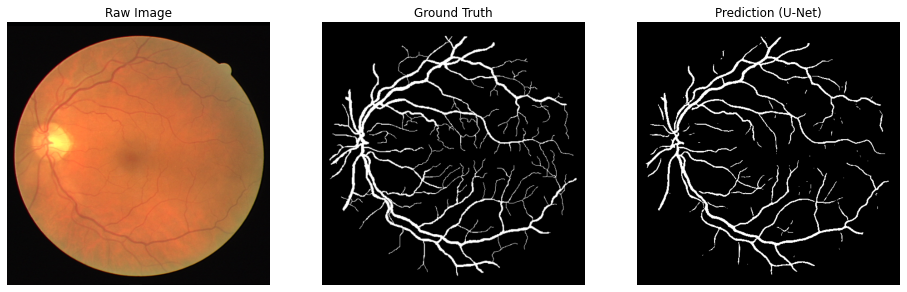

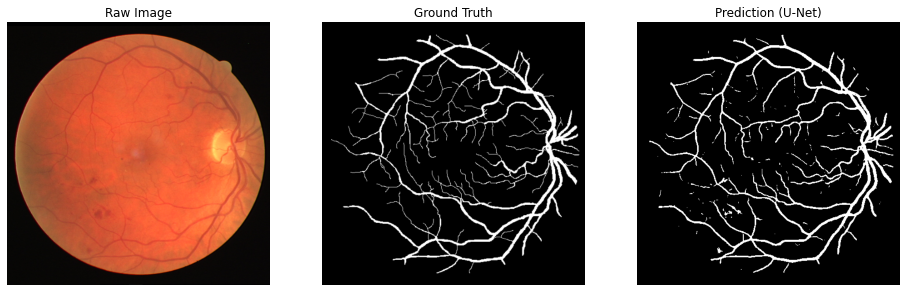

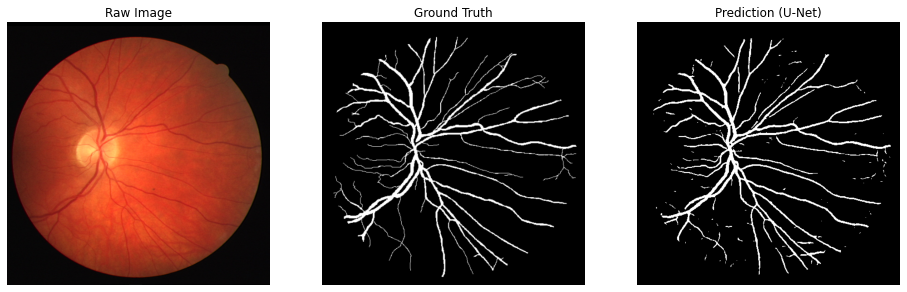

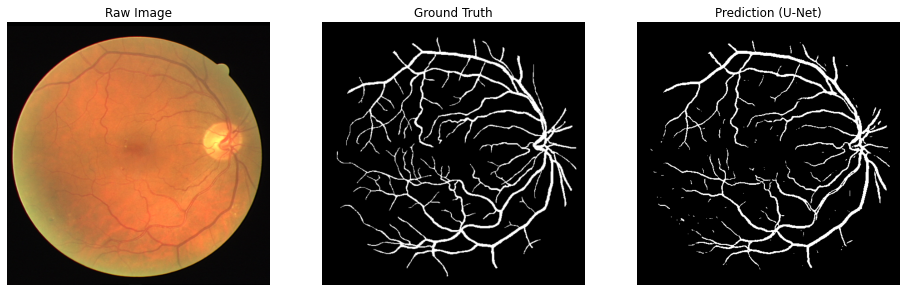

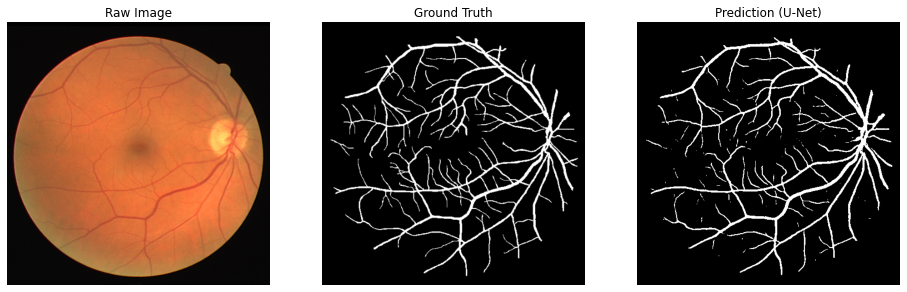

In [65]:
test_list = np.random.choice(len(test_imgs), 5)
#print(test_list)
for id_img in test_list:
  img, raw_img = read_img(test_imgs[id_img])
  mask, mask_original = read_mask(test_masks[id_img])
  prediction = segment_img(img, test_model)

  fig = plt.figure(figsize=(16, 8))
  fig.add_subplot(1,3,1)  
  plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.title("Raw Image")

  plt.subplot(1,3,2)
  plt.imshow(mask_original, cmap="gray")
  plt.axis("off")
  plt.title("Ground Truth") 
  
  plt.subplot(1,3,3)  
  plt.imshow(prediction, cmap="gray")
  plt.axis("off")
  plt.title("Prediction (U-Net)")   

(512, 512, 3)


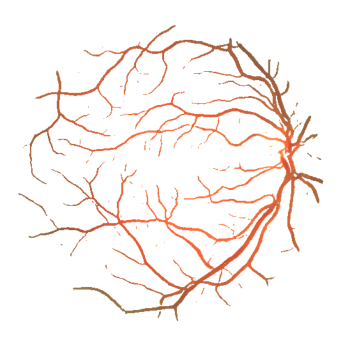

In [66]:
id_img = 17
img, raw_img = read_img(test_imgs[id_img])
mask, mask_original = read_mask(test_masks[id_img])
predicao = segment_img(img, test_model)
print(img.shape)

heigth, widht = img.shape[:2]
white_background = 255 * np.ones((heigth, widht, 3), dtype='uint8')
final_img = raw_img.copy()
final_img[predicao == 0] = white_background[predicao == 0]

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off');

# Evaluation

In [67]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import MeanIoU

In [68]:
id_img = 17
img, raw_img = read_img(test_imgs[id_img])
mask, mask_original = read_mask(test_masks[id_img])
prediction = segment_img(img, test_model)

In [70]:
mask.shape, prediction.shape

((512, 512), (512, 512))

In [71]:
pred_ = prediction.flatten()
mask_ = mask.flatten()
pred_.shape, mask_.shape

((262144,), (262144,))

In [72]:
# IoU
iou_result = MeanIoU(num_classes = 2)
iou_result.update_state(mask, prediction)
iou_value = iou_result.result().numpy()

In [73]:
mask_, np.unique(mask_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (array([0, 1], dtype=int32), array([249451,  12693])))

In [74]:
pred_, np.unique(pred_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (array([0, 1], dtype=int32), array([239471,  22673])))

In [75]:
acc_value = accuracy_score(mask_, pred_)

IoU:  0.47855845
Accuracy:  0.8837814331054688


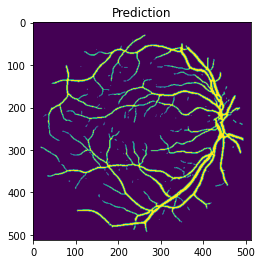

In [77]:
plt.imshow(predicao)
plt.title('Prediction')
print('IoU: ', iou_value)
print('Accuracy: ', acc_value)

In [ ]:
lista_scores = []
for x, y in tqdm(zip(test_imgs, test_masks), total=len(test_imgs)):
    nome = x.split("/")[-1].split(".")[0]

    img, img_original = ler_img(x)
    mask, mask_original = ler_mascara(y)
    predicao = segmenta_img(img, modelo_teste) 
    
    mask_ = mask.flatten()
    pred_ = predicao.flatten()

    IoU_resultado = MeanIoU(num_classes=2)  
    IoU_resultado.update_state(mask, predicao) 
    valor_iou = IoU_resultado.result().numpy() 
    
    valor_acc = accuracy_score(mask_, pred_)
    
    lista_scores.append([nome, valor_iou, valor_acc])

medias_score = [s[1:] for s in lista_scores]  
medias_score = np.mean(medias_score, axis=0)
print(f"\nMédia do IoU: {medias_score[0]:0.5f}") 
print(f"Média do Accuracy: {medias_score[1]:0.5f}")

100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Média do IoU: 0.75586
Média do Accuracy: 0.96081


In [ ]:
lista_scores

[['01_test', 0.70931387, 0.9448585510253906],
 ['02_test', 0.77852297, 0.9581680297851562],
 ['03_test', 0.76822853, 0.965057373046875],
 ['04_test', 0.7915313, 0.9659347534179688],
 ['05_test', 0.80066514, 0.969879150390625],
 ['06_test', 0.7797135, 0.96405029296875],
 ['07_test', 0.7790552, 0.9654045104980469],
 ['08_test', 0.7672547, 0.9659957885742188],
 ['09_test', 0.76392186, 0.9669342041015625],
 ['10_test', 0.7655168, 0.9652328491210938],
 ['11_test', 0.75088847, 0.9592971801757812],
 ['12_test', 0.7602062, 0.9624481201171875],
 ['13_test', 0.7793837, 0.9634437561035156],
 ['14_test', 0.73756206, 0.9575080871582031],
 ['15_test', 0.72691786, 0.961181640625],
 ['16_test', 0.7452074, 0.9564208984375],
 ['17_test', 0.74199, 0.9587631225585938],
 ['18_test', 0.72359335, 0.9541549682617188],
 ['19_test', 0.7254714, 0.9537010192871094],
 ['20_test', 0.7222345, 0.9578018188476562]]